# 트레이딩 프로젝트 : 10조

## 1) 모듈 import

In [2]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
from pykrx import stock
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from datetime import date
import plotly
import seaborn as sns
from pandas import Series

from mpl_finance import candlestick2_ohlc
import matplotlib.pyplot as plt

#matplotlib에서 x축과 y축에 표시되는 값을 ticker라 함
import matplotlib.ticker as ticker 
import matplotlib.dates as mdates

import warnings

warnings.filterwarnings(action='ignore')

In [3]:
import mplfinance as mpf
import pandas_datareader as web

import pandas_datareader as pdr
from pandas_datareader import data, wb

## 2) 코스피 100 에 해당하는 종목들을 크롤링 (네이버증권)

- kospi_df : 코스피 상위 100개 종목의 코드와 회사명을 저장한 dataframe type의 변수

In [4]:
from pykrx import stock

In [5]:
tic=stock.get_index_portfolio_deposit_file("1034","20180101")

tic

The date you entered 20180101 seems to be a holiday. PYKRX changes the date parameter to 20171228.


['005930',
 '000660',
 '005380',
 '005490',
 '035420',
 '051910',
 '105560',
 '012330',
 '032830',
 '207940',
 '015760',
 '028260',
 '055550',
 '017670',
 '034730',
 '096770',
 '051900',
 '090430',
 '066570',
 '251270',
 '033780',
 '003550',
 '018260',
 '086790',
 '006400',
 '000270',
 '010950',
 '000810',
 '011170',
 '002790',
 '000030',
 '034220',
 '036570',
 '010130',
 '035720',
 '024110',
 '030200',
 '004020',
 '139480',
 '035250',
 '009150',
 '021240',
 '018880',
 '008930',
 '161390',
 '128940',
 '032640',
 '006800',
 '088350',
 '078930',
 '009540',
 '023530',
 '001040',
 '009830',
 '086280',
 '005830',
 '004800',
 '097950',
 '004990',
 '047810',
 '029780',
 '009240',
 '001450',
 '000720',
 '012750',
 '002380',
 '036460',
 '005940',
 '071050',
 '011070',
 '008770',
 '016360',
 '010060',
 '000120',
 '003490',
 '000880',
 '007070',
 '138930',
 '011780',
 '000210',
 '012630',
 '010140',
 '004170',
 '007310',
 '000100',
 '030000',
 '069960',
 '047040',
 '047050',
 '004370',
 '000150',

In [6]:
kospi_df = pd.DataFrame()
kospi_df['Code'] = tic

kospi_df

,Code
0,005930
1,000660
2,005380
3,005490
4,035420
...,...
95,042670
96,034020
97,001800
98,005300


In [170]:
stockList = fdr.StockListing('KRX')

def crawling(page, kospi100):
    res = requests.get('https://finance.naver.com/sise/sise_market_sum.naver?&page='+str(page))
    soup = BeautifulSoup(res.content,'html.parser')
       
    items = soup.select('tbody > tr > td:nth-of-type(2) > a')
    
    for item in range(len(items)):
        name=items[item].contents[0]
        if (stockList[stockList['Name']==name]['ListingDate']<'2017-12-1').tolist():
            code=items[item].attrs['href'][-6:]
            kospi100[code]=name
            
            if len(kospi100)==100:
                break
                
    return kospi100

def Kospi_100(): #kospi 상위 100개 출력 함수
    
    page = 1
    kospi100=dict()
    
    while(len(kospi100)!=100):  
        kospi100=crawling(page,kospi100)
        page=page+1
        
    return kospi100


In [171]:
kospi100 = Kospi_100()

In [172]:
kospi_df = pd.DataFrame()

kospi_df['Code'] = kospi100.keys()
kospi_df['Name'] =kospi100.values()

kospi_df

,Code,Name
0,005930,삼성전자
1,373220,LG에너지솔루션
2,000660,SK하이닉스
3,207940,삼성바이오로직스
4,005935,삼성전자우
...,...,...
95,111770,영원무역
96,069620,대웅제약
97,064350,현대로템
98,133690,TIGER 미국나스닥100


## 3) 데이터 전처리

- 결측치 제거
- 0 인값 제거

### 코로나 이전 (before corona)

In [7]:
def cleaning(df):
        
    zero_val_o = df[df['Open']==0.0].index
    df.drop(zero_val_o,inplace=True)
    
    zero_val_c = df[df['Close']==0.0].index
    df.drop(zero_val_c,inplace=True)
    
    zero_val_h = df[df['High']==0.0].index
    df.drop(zero_val_h,inplace=True)
    
    zero_val_l = df[df['Low']==0.0].index
    df.drop(zero_val_l,inplace=True)
    
    #Nan 값 제거
    df=df.dropna()
    
    return df


In [8]:
for i in range(len(kospi_df)):
    
    code = kospi_df['Code'][i]
    start_date = '20180101'
    end_date='20191231'
    
    df = fdr.DataReader(code,start_date,end_date) 

    df = cleaning(df) 

## 4) Trading

### *strategy*


- **buy_signal이 0에서 1로 넘어가는 지점에서 매수**
- **sell_signal이 -1.0 이면 매도**
     + positions - 100주씩 거래

- initial_capital = 1억



In [13]:
def trading(df):
    
    #초기자본: 1억
    initial_capital=1e8
    

    #20일 이동평균선 구하기
    df['MA_20'] = df['Close'].rolling(20).mean()
    
    #매수 signal
    df['buy_signal'] = np.where(df['MA_20'] > df['Close'], 1.0, 0.0)
    
    #매도 signal
    df['sell_signal'] = 0.0

    for i in range(len(df)):
        if df['Close'][i-1] > df['Close'][i]:
            df['sell_signal'][i] = -1.0
        else:
            df['sell_signal'][i] = 0.0
            
    #return df
            
    #매수 & 매도 시점
    positions=pd.DataFrame()

    positions['buy'] = 100*df['buy_signal']
    positions['sell'] = 100*df['sell_signal']
    
    positions = pd.concat([positions['buy'], positions['sell']],axis=1)
    
    pos_diff_s = (positions['sell'].diff())
    pos_diff_b = (positions['buy'].diff())
                  
    pos_diff=pd.concat([pos_diff_s, pos_diff_b],axis=1)
    
    
    
    portfolio = positions.multiply(df['Close'],axis=0)
    
    portfolio['holdings_b']=(positions['buy'].multiply(df['Close'],axis=0))
    portfolio['holdings_s']=(positions['sell'].multiply(df['Close'],axis=0))
    
    portfolio['cash_s'] = initial_capital - (pos_diff_s.multiply(df['Close'],axis=0)).cumsum()
    portfolio['cash_b'] = initial_capital - (pos_diff_b.multiply(df['Close'],axis=0)).cumsum()
    
    
    portfolio['total_s'] = portfolio['cash_s'] + portfolio['holdings_s']
    portfolio['total_b'] = portfolio['cash_b'] + portfolio['holdings_b']
    portfolio['total'] = portfolio['total_s'] + portfolio['total_b']
    
    portfolio['returns']=(100*(portfolio['total']-initial_capital))/initial_capital
    
    cum_ret=[]
    
    cum_ret.append(portfolio['returns'][-1]) 
    
    
    return cum_ret, portfolio

In [11]:
#수익률


def returns(portfolio):
    
    portfolio['returns']=100*(portfolio['total']-initial_capital)/initial_capital
    
    #종목별 누적 수익률을 저장할 list
    
    rst.append(portfolio.iloc[-1:4].values) 
    
    return portfolio


In [12]:

result = Series(pd.concat([kospi100['Code'],rst],axis=1))
result.mean()
#tic 종목번호를 인덱스로 하여 종목번호와 수익률을 나타낸다
#s=Series(rst,tic)
#s.mean()


NameError: name 'portfolio' is not defined

### 수익률
- portfolio 
    + holdings : 현재 보유하고 있는 주식의 가치
    + pos_diff : 매수 & 매도 물량
    + cash : 현재 보유 현금
    + total : 총 자산 
    + returns : 수익률
    

## 특정 종목 지정

In [157]:
lg_sol = fdr.DataReader('373220','20180101')

In [159]:
lg_sol

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-01-27,597000,598000,450000,505000,15946992,NaN
2022-01-28,476000,483000,445000,450000,4559773,-0.108911
2022-02-03,458000,495500,441000,477000,2918435,0.060000
2022-02-04,476500,505000,476000,504000,2088996,0.056604
2022-02-07,520000,548000,511000,548000,1911176,0.087302
...,...,...,...,...,...,...
2022-05-23,438500,444000,432500,438000,361437,0.009217
2022-05-24,438500,444000,436500,438500,350284,0.001142
2022-05-25,439000,439000,422000,426500,365195,-0.027366


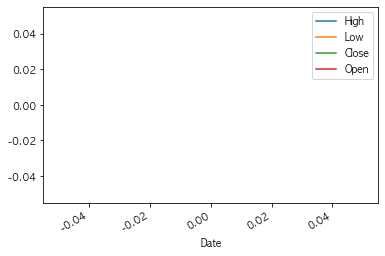

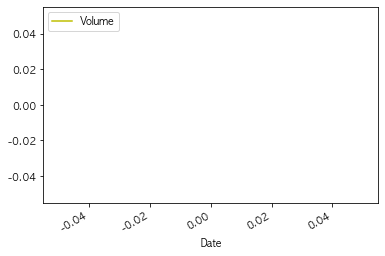

In [129]:
lg_sol[['High','Low','Close','Open']].plot()
plt.legend(loc='upper right')
plt.show()

lg_sol['Volume'].plot(color='y')
plt.legend(loc='upper left')

plt.show()

In [99]:
#삼성전자
se_df = fdr.DataReader('005930','20180101','20191231') 
len(se_df)

490

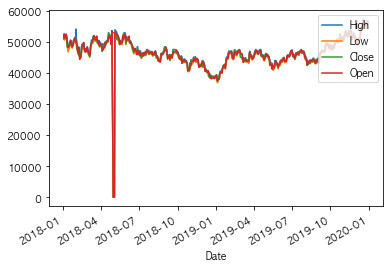

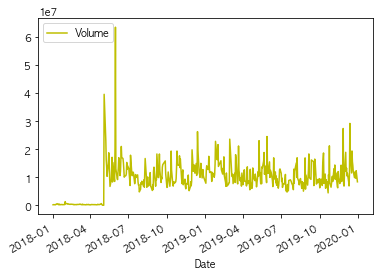

In [100]:
se_df[['High','Low','Close','Open']].plot()
plt.legend(loc='upper right')
plt.show()

se_df['Volume'].plot(color='y')
plt.legend(loc='upper left')

plt.show()

In [101]:
se_df = cleaning(se_df) 
len(se_df)

487

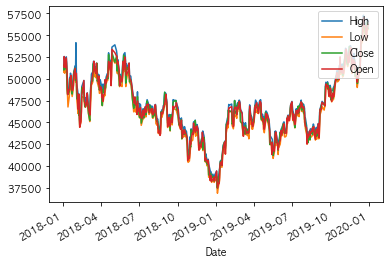

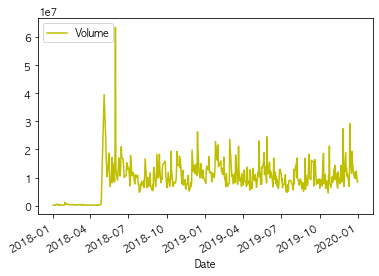

In [102]:
se_df[['High','Low','Close','Open']].plot()
plt.legend(loc='upper right')
plt.show()

se_df['Volume'].plot(color='y')
plt.legend(loc='upper left')

plt.show()

- 0인 값을 포함하는 행들과 Nan 값을 포함하는 행들을 모두 제거해주었다.

#### 4) trading

In [123]:

se_df_ = trading(se_df)
se_df_

([100.895],
             buy       sell  holdings_b  holdings_s       cash_s       cash_b  \
 Date                                                                           
 2018-01-02  0.0        0.0         0.0         0.0          NaN          NaN   
 2018-01-03  0.0        0.0         0.0         0.0  100000000.0  100000000.0   
 2018-01-04  0.0 -5108000.0         0.0  -5108000.0  105108000.0  100000000.0   
 2018-01-05  0.0        0.0         0.0         0.0   99896000.0  100000000.0   
 2018-01-08  0.0 -5202000.0         0.0  -5202000.0  105098000.0  100000000.0   
 ...         ...        ...         ...         ...          ...          ...   
 2019-12-23  0.0 -5550000.0         0.0  -5550000.0  106071000.0  100364000.0   
 2019-12-24  0.0 -5500000.0         0.0  -5500000.0  106071000.0  100364000.0   
 2019-12-26  0.0        0.0         0.0         0.0  100531000.0  100364000.0   
 2019-12-27  0.0        0.0         0.0         0.0  100531000.0  100364000.0   
 2019-12-30  0.0

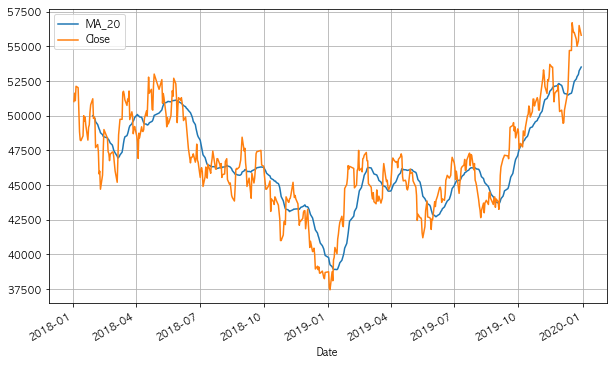

In [104]:
#이동평균값 plot 그리기
ma_plot = se_df[['MA_20','Close']].plot(figsize=(10,6))

ma_plot.plot()

ma_plot.legend(loc='best') #라벨 위치 설정

ma_plot.grid() #격자

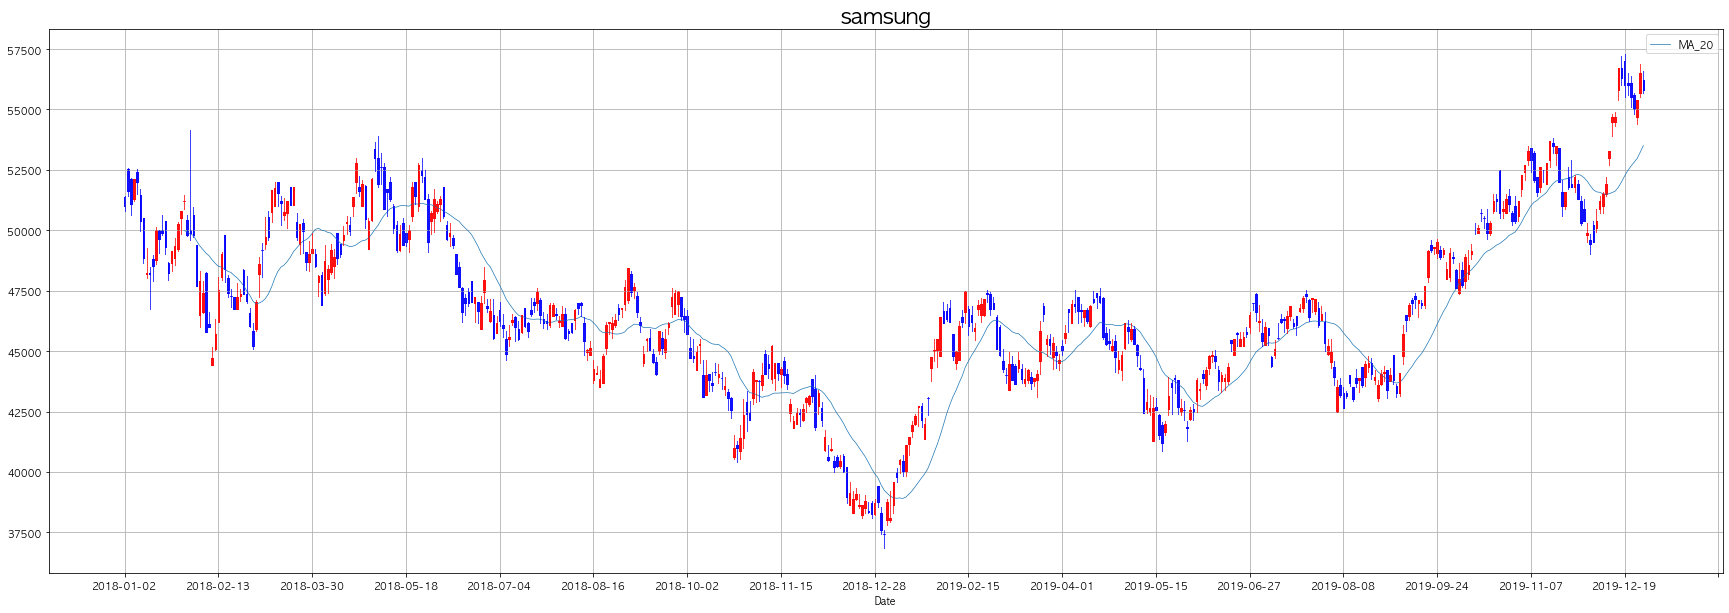

In [105]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)
index = se_df.index.astype('str') # 캔들스틱 x축이 str로 들어감

# 이동평균선 그리기
ax.plot(index, se_df['MA_20'], label='MA_20', linewidth=0.7)

# X축 티커 숫자 20개로 제한
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))

# 그래프 title과 축 이름 지정
ax.set_title('samsung', fontsize=22)
ax.set_xlabel('Date')

# 캔들차트 그리기
candlestick2_ohlc(ax, se_df['Open'], se_df['High'], 
                  se_df['Low'], se_df['Close'],
                  width=0.5, colorup='r', colordown='b')
ax.legend()
plt.grid()
plt.show()

### 수익률

In [121]:
cum_ret = pd.Series(cum_ret)
cum_ret

Series([], dtype: float64)

In [110]:
result = pd.concat([kospi_df['Code'],cum_ret],axis=1)
result.columns = ['Code','returns']

#result['returns'].mean()

result['returns'].describe()

count      1.000
mean     100.895
std          NaN
min      100.895
25%      100.895
50%      100.895
75%      100.895
max      100.895
Name: returns, dtype: float64

In [ ]:
ax=portfolio['total'].plot(figsize=(15,5),color='g')

#매수 or 매도 해야하는 지점 표기하여 plot


#1)매도
ax.plot(portfolio.loc[pos_diff_s==-100].index,
       portfolio.total[pos_diff_s==-100],
       "v", markersize=8, label='Sell')

#2)매수
ax.plot(portfolio.loc[pos_diff_b==100].index,
       portfolio.total[pos_diff_b==100],
       "^",markersize=8, label='Buy')

### 누적 수익률을 구해보자

In [ ]:
for i in range(len(kospi_df)):
    
    
    code = kospi_df['Code'][i]
    start_date = '20180101'
    end_date='20191231'
    
    df = fdr.DataReader(code,start_date,end_date) 

    df = cleaning(df) 
    
    before_df = trading(df)
    
return before_df

In [ ]:
result = pd.concat([kospi_df['Code'],cum_ret],axis=1)
result.columns = ['Code','returns']

#result['returns'].mean()

result['returns'].describe()

<AxesSubplot:>

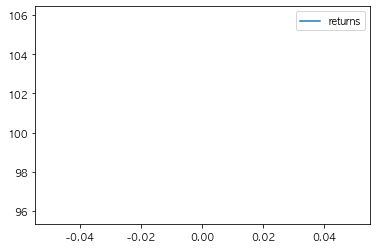

In [111]:
result.plot()